# Make a Lyot stop based on the WFIRST Cycle 5 telescope pupil

In [1]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import glob
import PIL.ImageDraw
import PIL.Image
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Set basic parameters

In [458]:
overwrite = False
secobs_key = "wfirstCycle5"
flip = True
iD = 40
oD = 90
D = 1000 # original pupil diameter
N = 128 # quadrant width after binning
symm = 'half' # set to either 'quart' or 'half'
pad = 19 # feature padding, units of thousandths of pupil diameter

In [459]:
#LS_dir = os.path.abspath("../InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v3/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/LS")
#LS_dir = os.path.normpath("/Users/neil/Box Sync/scda/InputMasks/LS")
#LS_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/LS")
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS")
telap_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/TelAp")

if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS already exists


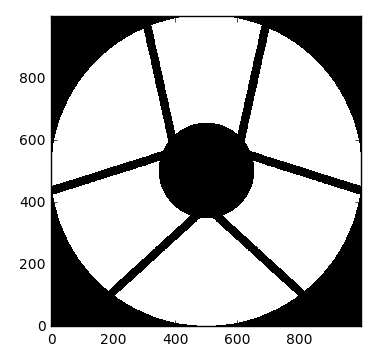

In [460]:
telap_fname_tail = "TelAp_half_wfirstCycle5_N{:04d}.dat".format(D/2)
telap_fname = os.path.join(telap_dir, telap_fname_tail)
telap_rhs = np.loadtxt(telap_fname)
wfirst_telap = np.concatenate([telap_rhs[:,::-1], telap_rhs], axis=1)
plt.imshow(wfirst_telap)

### Define annular stop

In [461]:
xs = np.linspace(-D/2 + 0.5, D/2 - 0.5, D)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (iD/100.*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (oD/100.*D/2)**2)
annular_stop = np.ones((D,D))
annular_stop[inside_ann] = 0.
annular_stop[outside_ann] = 0.

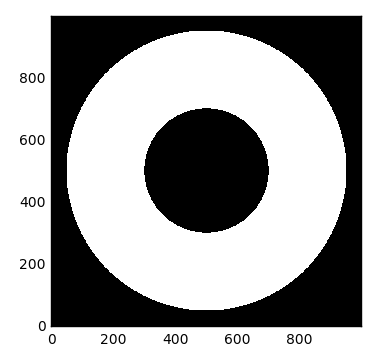

In [462]:
plt.imshow(annular_stop)

### Pad the telescope aperture

In [463]:
max_shift = int(round(D*float(pad)/1000))
shift_range = range(-max_shift,max_shift+1,1)

In [464]:
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
allowed_shifts.shape

(39, 39)

In [465]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
len(XYshifts_allowed)

1129

In [466]:
padded_wfirst_mask = np.ones(wfirst_telap.shape)
for (xshift,yshift) in XYshifts_allowed:
    wfirst_telap_shifted = np.roll(np.roll(wfirst_telap, yshift, 0), xshift, 1) 
    padded_wfirst_mask *= wfirst_telap_shifted

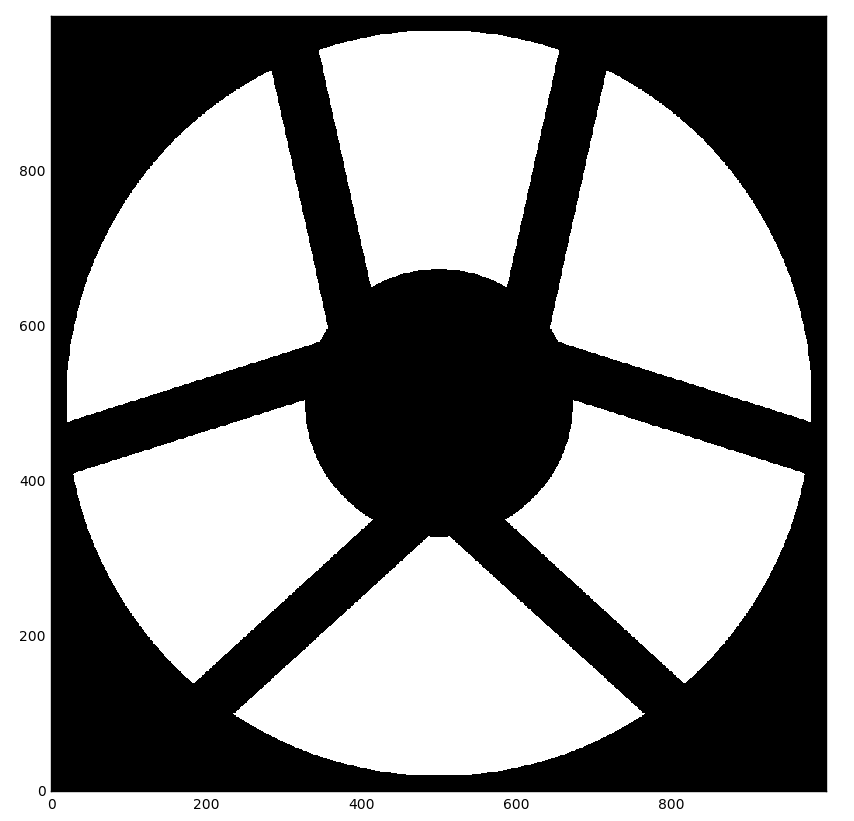

In [467]:
plt.figure(figsize=(10,10))
plt.imshow(padded_wfirst_mask)

In [468]:
wfirst_LS = padded_wfirst_mask*annular_stop

In [469]:
if flip:
    Lyot_stop = np.copy(wfirst_LS[::-1,:])
else:
    Lyot_stop = np.copy(wfirst_LS)

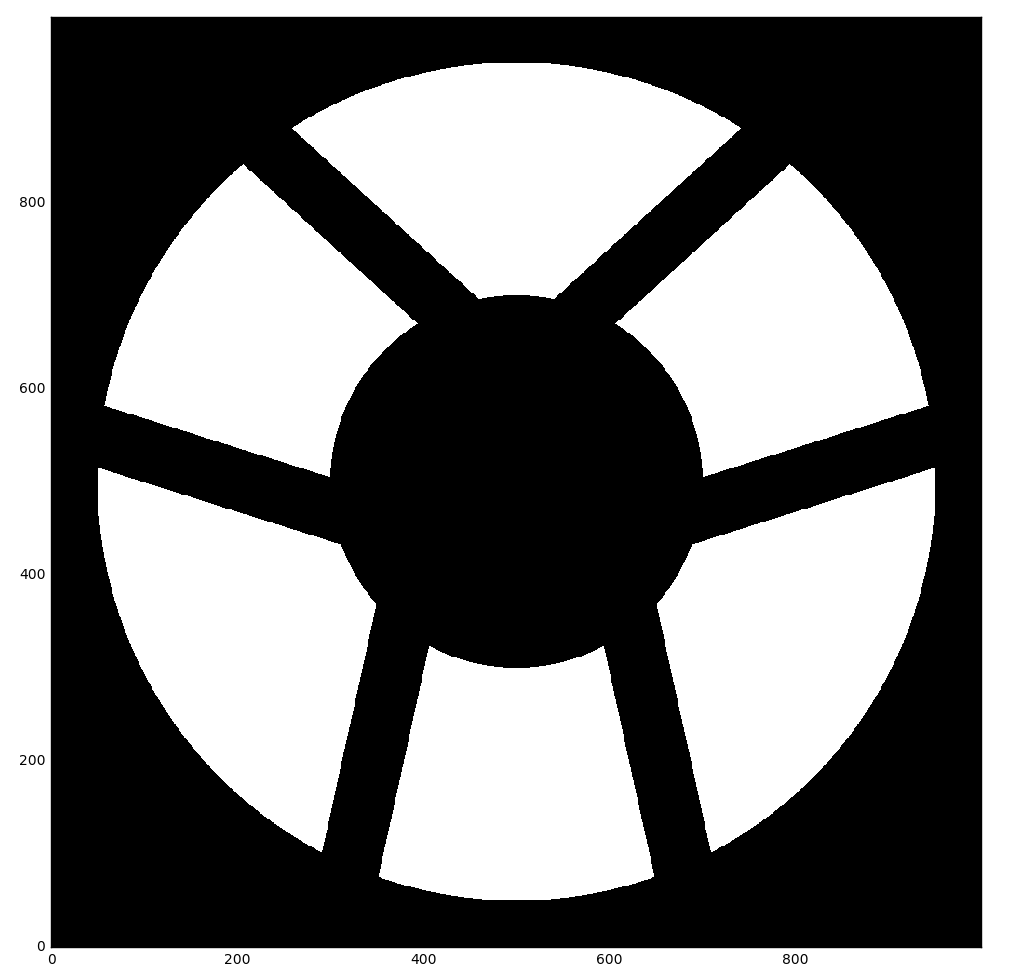

In [470]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [471]:
N_orig = D/2
#scalefac = int(N_orig/N)
#print("Binning the original LS array {0:d}x".format(scalefac))
#Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac,
#                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Lyot_stop_binned = skimage.transform.resize(Lyot_stop, (2*N, 2*N), order=1)

In [472]:
L_bin = Lyot_stop_binned.shape[0]

Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
print(Lyot_stop_binned_crop.shape)

Lyot_stop_full_binary = np.round(Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2-N:L_bin/2+N]).astype(int)

(256, 128)


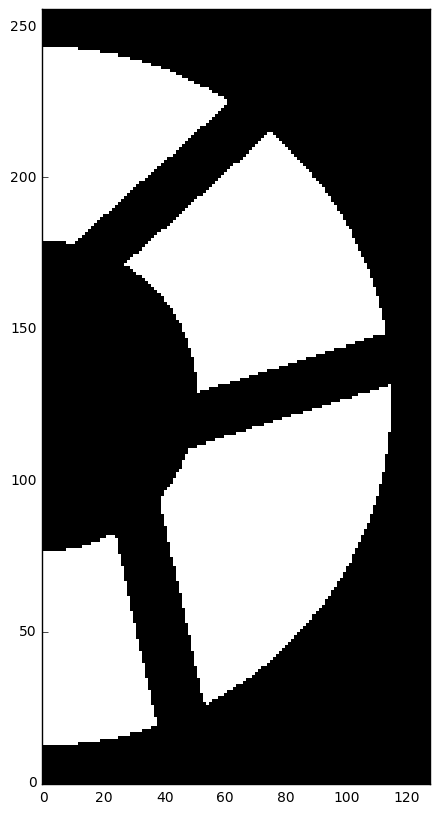

In [473]:
plt.figure(figsize=(20,10))
plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [474]:
if flip:
    LS_dat_fname_tail = "LS_half_ann{0:02d}D{1:02d}_{2:s}flipPad{3:02d}_N{4:04d}.dat".format(
                         iD, oD, secobs_key, pad, N)
else:
    LS_dat_fname_tail = "LS_half_ann{0:02d}D{1:02d}_{2:s}Pad{3:02d}_N{4:04d}.dat".format(
                         iD, oD, secobs_key, pad, N)

LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    #np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann40D90_wfirstCycle5flipPad19_N0128.dat


In [475]:
#os.listdir(LS_dir)
glob.glob('{:s}/LS_half_*wfirstCycle5*_N0128.dat'.format(LS_dir))

['/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_wfirstCycle5flipPad20_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann40D90_wfirstCycle5flipPad13_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann40D90_wfirstCycle5Pad13_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_wfirstCycle5Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_wfirstCycle5Pad07_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_wfirstCycle5Pad13_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann34D90_wfirstCycle5Pad19_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann36D90_wfirstCycle5Pad01_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_ann36D90_wfirstCycle5Pad07_N0128.dat',
 '/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/LS/LS_half_a

In [476]:
#os.remove(LS_dat_fname)